# House price prediction with scikit-learn

TODO:

PCA/feature selection

Removing outliers

Streamlining analysis with scikit

Adding also tensorflow/keras


In [2]:
import os
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("os.environ.get('KAGGLE_URL_BASE') == ", os.environ.get('KAGGLE_URL_BASE'))
if 'kaggle' in os.environ.get('KAGGLE_URL_BASE','localhost'):
    print("We are running on a Kaggle Server")
    IN_KAGGLE = True
else:
    IN_KAGGLE = False

os.environ.get('KAGGLE_URL_BASE') ==  None


In [16]:
if IN_COLAB:
    from google.colab import files
    !pip install kaggle
    if not os.path.exists("/root/.kaggle/kaggle.json")
        files.upload()
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    !kaggle competitions download -c house-prices-advanced-regression-techniques
    !unzip /content/house-prices-advanced-regression-techniques.zip


Saving kaggle.json to kaggle (1).json
Archive:  /content/house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: An
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 105MB/s]


In [47]:
if(IN_KAGGLE):
    train_path='../input/house-prices-advanced-regression-techniques/train.csv'
    test_path='../input/house-prices-advanced-regression-techniques/test.csv'
elif(IN_COLAB):
    train_path="/content/train.csv"
    test_path="/content/test.csv"
else:
    train_path='data/train.csv'
    test_path='data/test.csv'

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns

In [22]:
def plot_categorical(grouped,label,figsize=(12,8)):
    plt.figure(figsize=figsize)
    labels=[]
    data=[]
    for name,group in grouped:
        labels.append(name)
        data.append(group[label])
    plt.boxplot(data,labels=labels)
    plt.xlabel(name)
    plt.ylabel(label)
    plt.show()

Feature engineering function:

In [23]:
try:
    from house_prices_script import feat_eng
except:
    def feat_eng(df):
        ''' performs dataframe cleaning and basic feature engineering'''
        #total floors
        df['TotFlrSF']=df['1stFlrSF']+df['2ndFlrSF']
        #total number of floors (1 or 2)
        df['nFlrs']=df['2ndFlrSF'].map(lambda x: int(x>0)+1.)#if df['2ndFlrSF']>0 then df['nFlrs']=2
        df['GarageType']=df['GarageType'].fillna('NoGarage')
        df['GarageQual']=df['GarageQual'].fillna('NoGarage')
        df['GarageCond']=df['GarageCond'].fillna('NoGarage')
        df['PoolQC']=df['PoolQC'].fillna('NoPool')
        df['FireplaceQu']=df['FireplaceQu'].fillna('NoFp')
        #garage cars vs house size
        #number of bathrooms vs house size/n bedrooms
        return df

# Real estate price prediction

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Notes: lots of columns -> possible PCA? (see ml-basic-> clustering tutorial for info on PCA with sklearn)

In [48]:
train,test=pd.read_csv(train_path),pd.read_csv(test_path)
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [49]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [50]:
train,test=feat_eng(train),feat_eng(test)

In [51]:
count=test.isna().sum()
count=pd.DataFrame(count)
count[count[0]!=0]

,0
MSZoning,4
LotFrontage,227
Alley,1352
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,16
MasVnrArea,15
BsmtQual,44
BsmtCond,45


In [52]:
features=test.keys()


In [53]:
len(features)

82

In [54]:
label='SalePrice'

#### Plotting raw features

In [55]:
plot=True


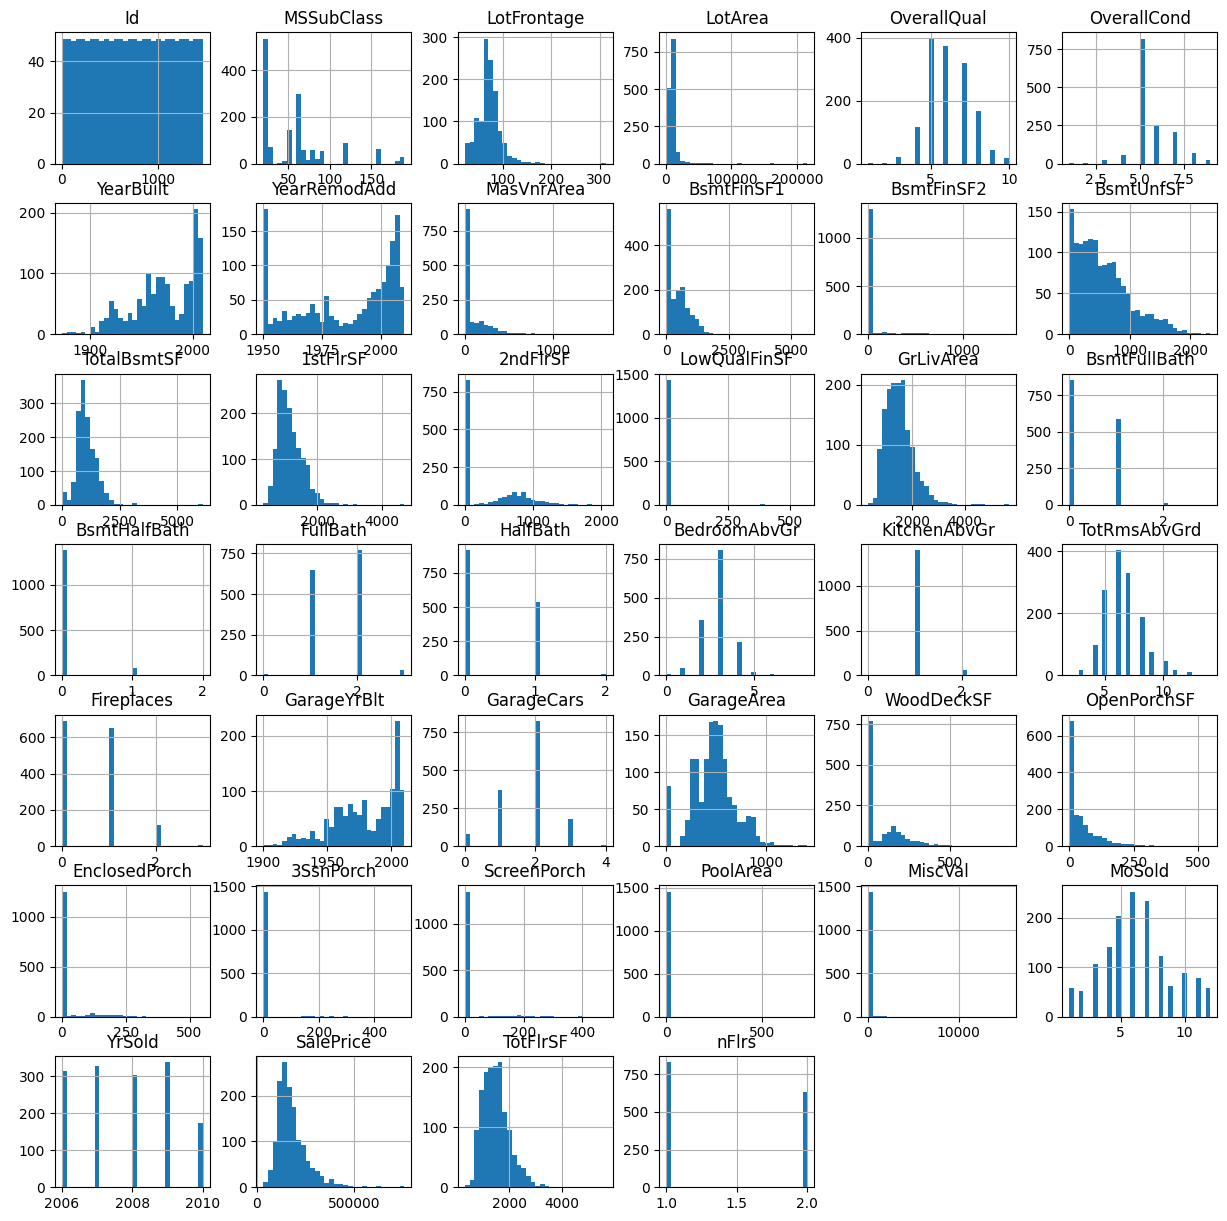

In [56]:
train.hist(bins=30, figsize=(15,15))
plt.show()

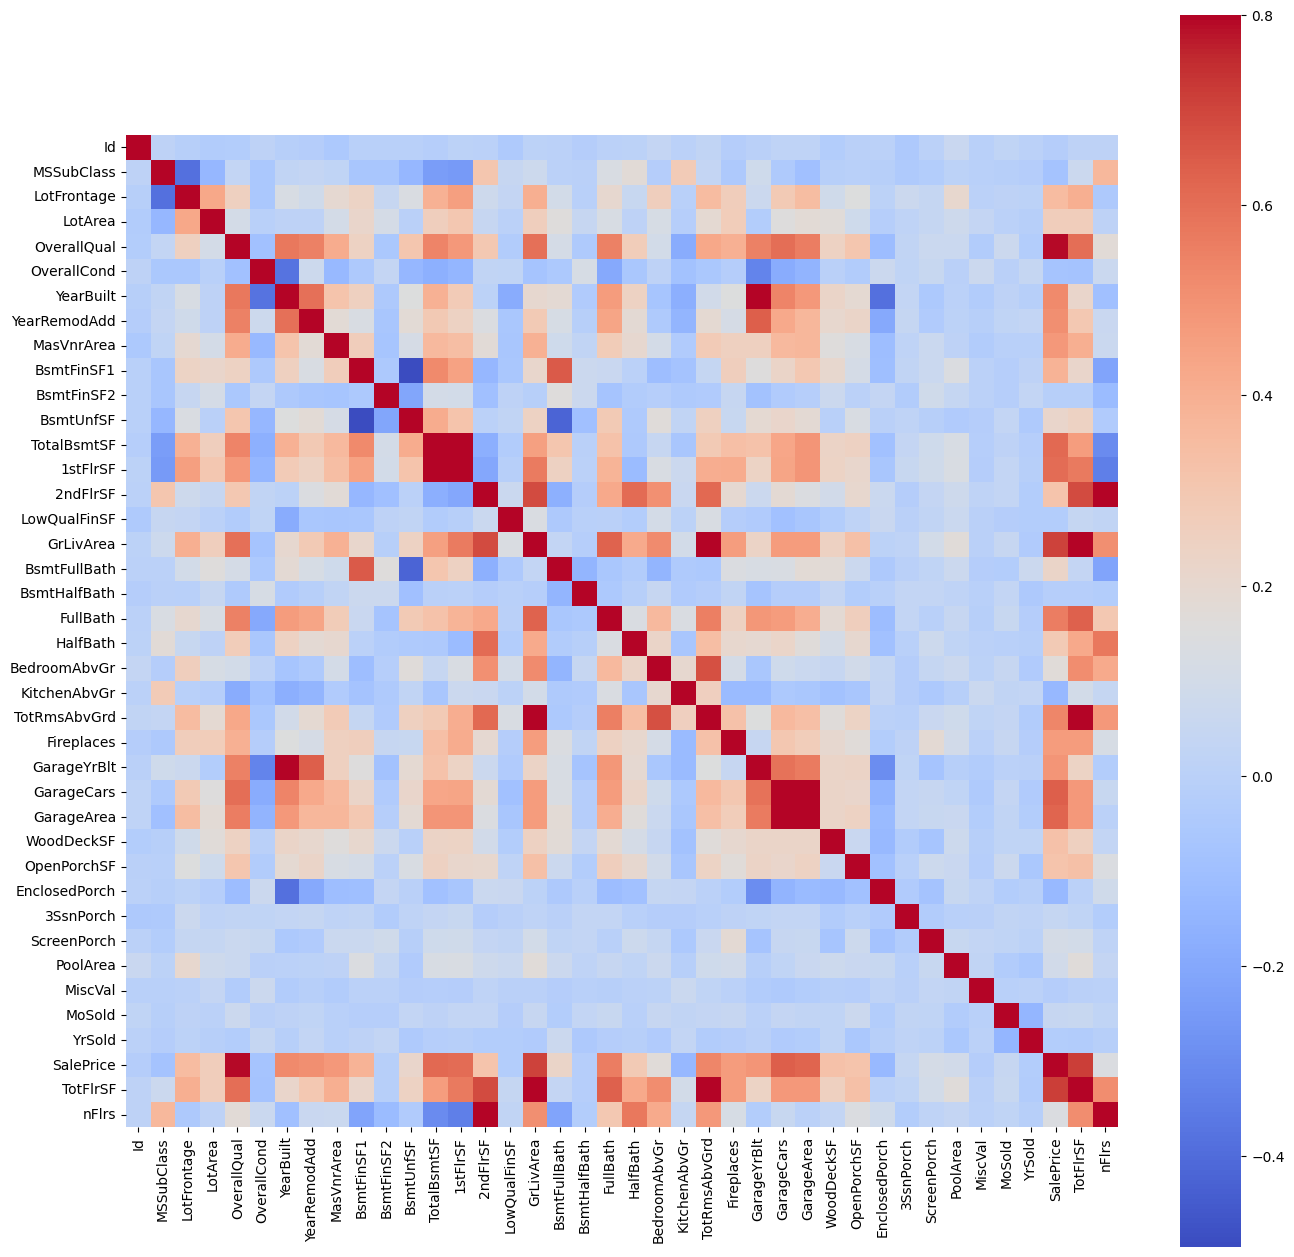

In [57]:
corrmat = train.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="coolwarm")
plt.show()

In [58]:
def plot_synth_f(df:pd.DataFrame,plot_type='s',sf='synth',label='SalePrice'):
    #definition of synthetic feature here
    df[sf]=df['TotFlrSF']#how do I pass a function on the dataframe?
    if plot_type=='c':
        grouped=df.groupby(sf)
        plot_categorical(grouped)
    else:
        plt.scatter(df[sf],df[label])
        plt.xlabel(sf)
        plt.ylabel(label)
        z = np.polyfit(df[sf],df[label], 1)
        p = np.poly1d(z)
        plt.plot(df[sf],p(df[sf]), color='magenta')

Let's see if we can do some feature engineering.

First: find if there are nan entries:

In [59]:
subset_df = train.loc[:, train.isnull().any()]

subset_df

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageYrBlt,GarageFinish,Fence,MiscFeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,2003.0,RFn,NaN,NaN
1,80.0,NaN,None,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,1976.0,RFn,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,2001.0,RFn,NaN,NaN
3,60.0,NaN,None,0.0,TA,Gd,No,ALQ,Unf,SBrkr,1998.0,Unf,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,2000.0,RFn,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,NaN,None,0.0,Gd,TA,No,Unf,Unf,SBrkr,1999.0,RFn,NaN,NaN
1456,85.0,NaN,Stone,119.0,Gd,TA,No,ALQ,Rec,SBrkr,1978.0,Unf,MnPrv,NaN
1457,66.0,NaN,None,0.0,TA,Gd,No,GLQ,Unf,SBrkr,1941.0,RFn,GdPrv,Shed
1458,68.0,NaN,None,0.0,TA,TA,Mn,GLQ,Rec,FuseA,1950.0,Unf,NaN,NaN


In [60]:
def count_na_per_col(df):
    count=df.isna().sum()
    count=pd.DataFrame(count).T
    return count

In [61]:
count_na_per_col(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotFlrSF,nFlrs
0,0,0,0,259,0,0,1369,0,0,0,...,1179,1406,0,0,0,0,0,0,0,0


In [62]:
pd.concat([count_na_per_col(train),count_na_per_col(test)])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotFlrSF,nFlrs
0,0,0,0,259,0,0,1369,0,0,0,...,1179,1406,0,0,0,0,0,0.0,0,0
0,0,0,4,227,0,0,1352,0,0,2,...,1169,1408,0,0,0,1,0,NaN,0,0


#### Selecting the interesting features

In [63]:
int_cat_f=['SaleCondition','TotRmsAbvGrd','ExterQual','Exterior1st','Neighborhood',
            'GarageFinish','KitchenQual','SaleType','PoolQC', 'OverallCond',
            'FullBath','HouseStyle','Condition1','MSZoning','BldgType','BsmtQual']
int_num_f=['LotArea','LotFrontage','BsmtFinSF1','TotalBsmtSF',
            'GrLivArea','GarageYrBlt','GarageArea','YearBuilt','MSSubClass','GarageCars','OverallQual']
int_ord_f=[]

In [64]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotFlrSF,nFlrs
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,1710,2.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,1262,1.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,1786,2.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,1717,2.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,2198,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,8,2007,WD,Normal,175000,1647,2.0
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,MnPrv,NaN,0,2,2010,WD,Normal,210000,2073,1.0
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,GdPrv,Shed,2500,5,2010,WD,Normal,266500,2340,2.0
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,4,2010,WD,Normal,142125,1078,1.0


In [65]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

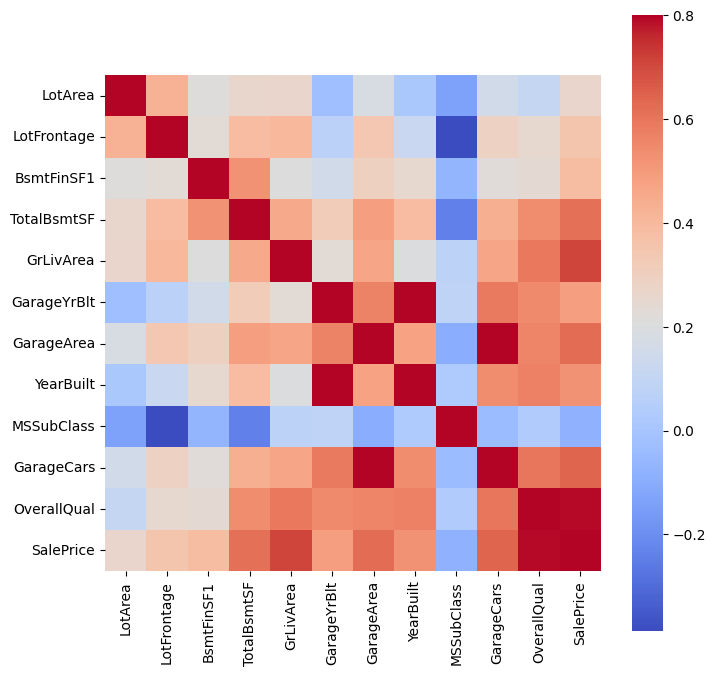

In [66]:
corrmat = train[int_num_f+[label]].corr()
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="coolwarm")
plt.show()

## Beginning regressions

In [67]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import set_config
from sklearn.metrics import r2_score,make_scorer,mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
#from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [68]:
train[train['GarageCars'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotFlrSF,nFlrs


In [69]:
#try using keras model in scikit pipeline.. or just do it all in tensorflow/keras?
#from keras.wrappers.scikit_learn import KerasRegressor


In [70]:
params = [{'regressor': [GradientBoostingRegressor()],
 'regressor__learning_rate': [0.03,0.1, 0.5, 1.0],
 'regressor__n_estimators' : [25,50, 100, 150,200]
 },
 {
    'regressor':[RandomForestRegressor()],
    'regressor__n_estimators' : [25,50, 100, 150,200]
 },
 {
   'regressor':[AdaBoostRegressor()],
   'regressor__learning_rate':[0.03,0.1, 0.5, 1.0],
   'regressor__n_estimators' : [25,50, 100, 150,200],
   'regressor__loss':['linear','square']
 }
#  ,
#  {
#   'regressor':[\()],
#   'regressor__gamma':[0,1,10,1000],
#   'regressor__eta':[0.1,0.2,0.3,0.4],
#  }
 ]

https://stackoverflow.com/questions/38555650/try-multiple-estimator-in-one-grid-search

In [71]:
# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_transformer = Pipeline(steps=[
    ('inp',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

binned_transformer = Pipeline(steps=[('inp',SimpleImputer(strategy='median')),
                                    ('KBinsDiscretizer',KBinsDiscretizer(n_bins=10))])

ordinal_transformer = Pipeline(steps=[
    ('ordenc', OrdinalEncoder())])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, int_num_f),
        ('cat', categorical_transformer, int_cat_f),
        ('ord', ordinal_transformer, int_ord_f)
        ])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])

In [72]:

def pipeline_builder(n_cols,c_cols,o_cols,b_cols):
    numeric_transformer = Pipeline(steps=[
        ('inp',SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    binned_transformer = Pipeline(steps=[('inp',SimpleImputer(strategy='median')),
                                    ('KBinsDiscretizer',KBinsDiscretizer(n_bins=10))])
    ordinal_transformer = Pipeline(steps=[('onehot', OrdinalEncoder())])
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, n_cols),
        ('cat', categorical_transformer, c_cols),
        ('ord', ordinal_transformer, o_cols),
        ('bin',binned_transformer, b_cols)
        ])
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])
    pipeline
    return pipeline

In [73]:
score = make_scorer(r2_score)

pipe=pipeline_builder(int_num_f,int_cat_f,int_ord_f,[])

gridsearch=GridSearchCV(verbose=1,estimator=pipe,param_grid=params,scoring=score,return_train_score=False,cv=3,n_jobs=2)


Create feature an label sets, drop outlier coumns

In [74]:
def xy_split(df,label):
    x,y=df.drop(label,axis=1),df[label]
    return x,y

In [75]:
x,y=train.drop([523,1298]).drop(label,axis=1),train.drop([523,1298])[label]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)


In [76]:
set_config(display='diagram')
gridsearch

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('inp',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotArea',
                                                                          'LotFrontage',
                                                                          'BsmtFinSF1',
                                                                          'TotalBsmtSF',
                                                                          'GrLivArea',
                                                                          'GarageYrBlt',
                                                                          'GarageArea',
                                                                          'YearBuilt',
                                                                          'MSSubClass',
                                                                          'GarageCars',
                                                                          'OverallQual']),
                                                                        ('cat',
                                                                         Pipeline(ste...
                          'regressor__learning_rate': [0.03, 0.1, 0.5, 1.0],
                          'regressor__n_estimators': [25, 50, 100, 150, 200]},
                         {'regressor': [RandomForestRegressor()],
                          'regressor__n_estimators': [25, 50, 100, 150, 200]},
                         {'regressor': [AdaBoostRegressor()],
                          'regressor__learning_rate': [0.03, 0.1, 0.5, 1.0],
                          'regressor__loss': ['linear', 'square'],
                          'regressor__n_estimators': [25, 50, 100, 150, 200]}],
             scoring=make_scorer(r2_score), verbose=1)

In [77]:
model1=gridsearch.fit(x_train,(y_train))

Fitting 3 folds for each of 65 candidates, totalling 195 fits


In [78]:
#model1.cv_results_

In [79]:
model1.best_score_

0.8870583983189428

In [80]:
model1.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('inp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'BsmtFinSF1', 'TotalBsmtSF',
                                                   'GrLivArea', 'GarageYrBlt',
                                                   'GarageArea', 'YearBuilt',
                                                   'MSSubClass', 'GarageCars',
                                                   'OverallQual']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(...
                                                   'KitchenQual', 'SaleType',
                                                   'PoolQC', 'OverallCond',
                                                   'FullBath', 'HouseStyle',
                                                   'Condition1', 'MSZoning',
                                                   'BldgType', 'BsmtQual']),
                                                 ('ord',
                                                  Pipeline(steps=[('onehot',
                                                                   OrdinalEncoder())]),
                                                  []),
                                                 ('bin',
                                                  Pipeline(steps=[('inp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('KBinsDiscretizer',
                                                                   KBinsDiscretizer(n_bins=10))]),
                                                  [])])),
                ('regressor', GradientBoostingRegressor(n_estimators=200))])

In [81]:
import datetime

In [82]:
savemodel=True

In [83]:
if savemodel:
    timestamp=datetime.datetime.now().strftime("%d%m%Y%H%M%S")
    models_folder= 'models'
    os.makedirs(models_folder,exist_ok=True)
    model_name= 'model_'+ timestamp +'.joblib'
    modelpath= os.path.join(models_folder,model_name)
    from joblib import dump, load
    dump(model1, modelpath)
    print('Saved ' , modelpath)

Saved  models/model_02102023183535.joblib


In [84]:
def score_and_visualize(model,x_test,y_test):
    predictions=model.predict(x_test)
    plt.figure(figsize=(10,10))
    plt.scatter(y_test,predictions)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    msle=mean_squared_log_error(y_true=y_test, y_pred=predictions)#msle is the metric evaluated in the kaggle challange
    r2=r2_score(y_true=y_test, y_pred=predictions)
    print('r2 coefficient: ',r2,'\nmsle = ', msle)
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.axline((0,0),slope=1,ls='--')
    plt.show()

In [85]:
#len(model2[1].feature_importances_)

r2 coefficient:  0.923362084416828 
msle =  0.01400793733208582


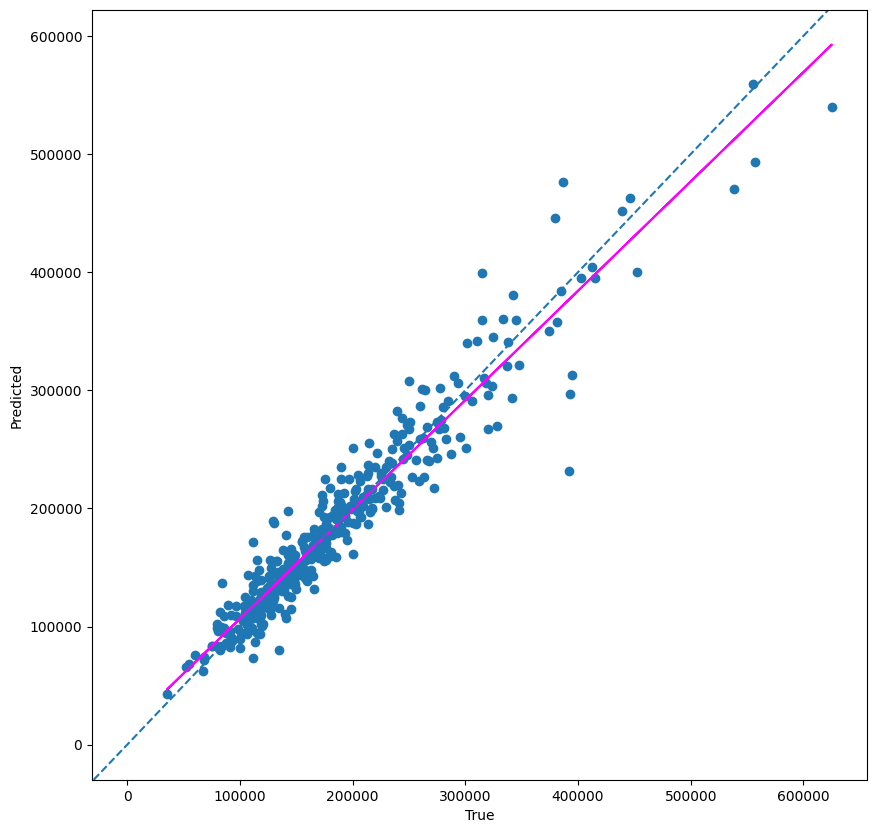

In [86]:
score_and_visualize(model=model1,x_test=x_test,y_test=y_test)
#score_and_visualize(model=model2,x_test=x_test,y_test=y_test)

## Now make predictions on the test dataset

In [89]:
if IN_KAGGLE:
    sample_sub=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
elif IN_COLAB:
    sample_sub=pd.read_csv('/content/sample_submission.csv')
else:
    sample_sub=pd.read_csv('data/sample_submission.csv')
sample_sub


,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


### Make prediction and save

In [90]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotFlrSF,nFlrs
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,NoPool,MnPrv,NaN,0,6,2010,WD,Normal,896,1.0
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,NoPool,NaN,Gar2,12500,6,2010,WD,Normal,1329,1.0
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,NoPool,MnPrv,NaN,0,3,2010,WD,Normal,1629,2.0
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,NoPool,NaN,NaN,0,6,2010,WD,Normal,1604,2.0
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,NoPool,NaN,NaN,0,1,2010,WD,Normal,1280,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NoPool,NaN,NaN,0,6,2006,WD,Normal,1092,2.0
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,NoPool,NaN,NaN,0,4,2006,WD,Abnorml,1092,2.0
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,NoPool,NaN,NaN,0,9,2006,WD,Abnorml,1224,1.0
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,NoPool,MnPrv,Shed,700,7,2006,WD,Normal,970,1.0


In [91]:
#make prediction on the test set and save
pred=model1.predict(test)
pred

array([124151.1091075 , 175324.0707883 , 174643.73633594, ...,
       148218.3117343 , 129663.47303059, 231370.926797  ])

In [92]:
write=True

In [94]:
if IN_KAGGLE:
    out_df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
elif IN_COLAB:
    out_df=pd.read_csv('/content/sample_submission.csv')
else:
    out_df=pd.read_csv('data/sample_submission.csv')
out_df['SalePrice']=pred
if write:
    out_df.to_csv('prediction.csv',index=False)

In [95]:
f = lambda x: model1.predict(
    pd.DataFrame(x, columns=test.columns)
)

In [96]:
test.iloc[:4,:]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotFlrSF,nFlrs
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,NoPool,MnPrv,NaN,0,6,2010,WD,Normal,896,1.0
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,NoPool,NaN,Gar2,12500,6,2010,WD,Normal,1329,1.0
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,NoPool,MnPrv,NaN,0,3,2010,WD,Normal,1629,2.0
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,NoPool,NaN,NaN,0,6,2010,WD,Normal,1604,2.0


In [99]:
if IN_COLAB:
    !pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.8 MB/s eta 0:00:00


In [ ]:

import shap

# train an XGBoost model
subs=test.iloc[:100,:]

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.KernelExplainer(f, subs)
shap_values = explainer(subs)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
shap.initjs()


In [ ]:
shap.initjs()
shap.plots.force(shap_values[1])

In [ ]:
shap.plots.force(shap_values[:500])

In [ ]:
shap_values

In [ ]:
shap.plots.beeswarm(shap_values)